In [106]:
import time
import joblib
import os
import os.path as osp
import tensorflow as tf
import torch
from spinup import EpochLogger
from spinup.utils.logx import restore_tf_graph

In [107]:
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display

In [108]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [109]:
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [110]:
# variables
## target file path
fpath = '/workspaces/play-spinningup-with-docker/spinningup/data/installtest/installtest_s0'
length = 0
episodes = 10
norender = False
itr_num = -1
deterministic = False

In [111]:
itr = itr_num if itr_num >=0 else 'last'

In [112]:
def load_tf_policy(fpath, itr, deterministic=False):
    """ Load a tensorflow policy saved with Spinning Up Logger."""

    fname = osp.join(fpath, 'tf1_save'+itr)
    print('\n\nLoading from %s.\n\n'%fname)

    # load the things!
    sess = tf.Session()
    model = restore_tf_graph(sess, fname)

    # get the correct op for executing actions
    if deterministic and 'mu' in model.keys():
        # 'deterministic' is only a valid option for SAC policies
        print('Using deterministic action op.')
        action_op = model['mu']
    else:
        print('Using default action op.')
        action_op = model['pi']

    # make function for producing an action given a single state
    get_action = lambda x : sess.run(action_op, feed_dict={model['x']: x[None,:]})[0]

    return get_action

In [113]:
def load_pytorch_policy(fpath, itr, deterministic=False):
    """ Load a pytorch policy saved with Spinning Up Logger."""
    
    fname = osp.join(fpath, 'pyt_save', 'model'+itr+'.pt')
    print('\n\nLoading from %s.\n\n'%fname)

    model = torch.load(fname)

    # make function for producing an action given a single state
    def get_action(x):
        with torch.no_grad():
            x = torch.as_tensor(x, dtype=torch.float32)
            action = model.act(x)
        return action

    return get_action

In [114]:
"""
Load a policy from save, whether it's TF or PyTorch, along with RL env.

Not exceptionally future-proof, but it will suffice for basic uses of the 
Spinning Up implementations.

Checks to see if there's a tf1_save folder. If yes, assumes the model
is tensorflow and loads it that way. Otherwise, loads as if there's a 
PyTorch save.
"""

# determine if tf save or pytorch save
if any(['tf1_save' in x for x in os.listdir(fpath)]):
    backend = 'tf1'
else:
    backend = 'pytorch'

# handle which epoch to load from
if itr=='last':
    # check filenames for epoch (AKA iteration) numbers, find maximum value

    if backend == 'tf1':
        saves = [int(x[8:]) for x in os.listdir(fpath) if 'tf1_save' in x and len(x)>8]

    elif backend == 'pytorch':
        pytsave_path = osp.join(fpath, 'pyt_save')
        # Each file in this folder has naming convention 'modelXX.pt', where
        # 'XX' is either an integer or empty string. Empty string case
        # corresponds to len(x)==8, hence that case is excluded.
        saves = [int(x.split('.')[0][5:]) for x in os.listdir(pytsave_path) if len(x)>8 and 'model' in x]

    itr = '%d'%max(saves) if len(saves) > 0 else ''

else:
    assert isinstance(itr, int), \
        "Bad value provided for itr (needs to be int or 'last')."
    itr = '%d'%itr

# load the get_action function
if backend == 'tf1':
    get_action = load_tf_policy(fpath, itr, deterministic)
else:
    get_action = load_pytorch_policy(fpath, itr, deterministic)

# try to load environment from save
# (sometimes this will fail because the environment could not be pickled)
try:
    state = joblib.load(osp.join(fpath, 'vars'+itr+'.pkl'))
    env = state['env']
except:
    env = None



Loading from /workspaces/play-spinningup-with-docker/spinningup/data/installtest/installtest_s0/pyt_save/model.pt.




/usr/local/pip-global/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [115]:
max_ep_len = length
num_episodes = episodes
render = not(norender)

logger = EpochLogger()

Logging data to /tmp/experiments/1643519079/progress.txt


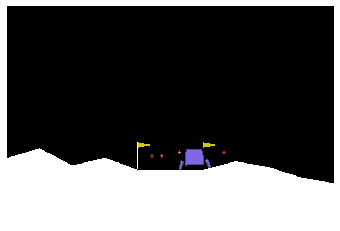

In [116]:
assert env is not None, \
    "Environment not found!\n\n It looks like the environment wasn't saved, " + \
    "and we can't run the agent in it. :( \n\n Check out the readthedocs " + \
    "page on Experiment Outputs for how to handle this situation."

%matplotlib inline
o, r, d, ep_ret, ep_len, n = env.reset(), 0, False, 0, 0, 0
img = plt.imshow(env.render(mode='rgb_array'))
results_plot = []
while n < num_episodes:
    if render:
        img.set_data(env.render(mode='rgb_array'))
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1e-3)

    a = get_action(o)
    o, r, d, _ = env.step(a)
    ep_ret += r
    ep_len += 1

    if d or (ep_len == max_ep_len):
        logger.store(EpRet=ep_ret, EpLen=ep_len)
        results_plot.append('Episode %d \t EpRet %.3f \t EpLen %d'%(n, ep_ret, ep_len))
        o, r, d, ep_ret, ep_len = env.reset(), 0, False, 0, 0
        n += 1

In [117]:
for result in results_plot:
    print(result)

logger.log_tabular('EpRet', with_min_and_max=True)
logger.log_tabular('EpLen', average_only=True)
logger.dump_tabular()

Episode 0 	 EpRet -114.147 	 EpLen 560
Episode 1 	 EpRet 127.228 	 EpLen 941
Episode 2 	 EpRet 76.064 	 EpLen 1000
-------------------------------------
|    AverageEpRet |            29.7 |
|        StdEpRet |             104 |
|        MaxEpRet |             127 |
|        MinEpRet |            -114 |
|           EpLen |             834 |
-------------------------------------
